In [726]:
import numpy as np
import scipy as sp
import pandas as pd

import scipy.interpolate as interpolate

import matplotlib.pyplot as plt

%matplotlib inline

In [727]:
N = 5
test_N = 50

In [728]:
def target_fn(x):
    return np.sin(x)

def sample(n, noise=False):
    x = np.sort(np.random.randn(n))
    samples = target_fn(x)
    
    if noise:
        samples += np.random.randn(n)
    
    return x, samples

In [729]:
def smooth(x, y):
    
    x_smooth = np.linspace(x.min(), x.max(), 300)
    
    t, c, k = interpolate.splrep(x, y, s=0, k=3)
    
    spline = interpolate.BSpline(t, c, k, extrapolate=False)
    
    y_smooth = spline(x_smooth)
    
    return x_smooth, y_smooth

In [730]:
def _getAplus(A):
    eigval, eigvec = np.linalg.eig(A)
    Q = np.matrix(eigvec)
    xdiag = np.matrix(np.diag(np.maximum(eigval, 0)))
    return Q*xdiag*Q.T

def _getPs(A, W=None):
    W05 = np.matrix(W**.5)
    return  W05.I * _getAplus(W05 * A * W05) * W05.I

def _getPu(A, W=None):
    Aret = np.array(A.copy())
    Aret[W > 0] = np.array(W)[W > 0]
    return np.matrix(Aret)

def nearPD(A, nit=10):
    n = A.shape[0]
    W = np.identity(n) 
    # W is the matrix used for the norm (assumed to be Identity matrix here)
    # the algorithm should work for any diagonal W
    deltaS = 0
    Yk = A.copy()
    for k in range(nit):
        Rk = Yk - deltaS
        Xk = _getPs(Rk, W=W)
        deltaS = Xk - Rk
        Yk = _getPu(Xk, W=W)
    return Yk

# GP using noise-free observations

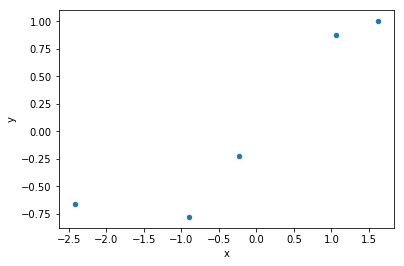

In [731]:
train_x, train_y = sample(N)
data = pd.DataFrame({"x": train_x, "y": train_y})
data.plot.scatter(x="x", y="y")

In [732]:
test_x, test_y = sample(test_N)
test_x = np.sort(np.concatenate([test_x, train_x]))

In [733]:
def kernel(x, x_):
    return np.exp(-.5*(x - x_)**2)

def cov(x, x_):
    xx, xx_ = np.meshgrid(x, x_)
    
    return np.reshape(kernel(xx, xx_), (x.shape[0], x_.shape[0]))

def gp_prior(x):
    
    return np.zeros(x.shape[0]), cov(x, x)

def gp_posterior(x, y, test_x):
    
    K_train = cov(x, x)
    K_test = cov(test_x, test_x)
    K_train_test = cov(x, test_x)
    
    K_train_inv = sp.linalg.inv(K_train)
    
    KK = np.dot(np.transpose(K_train_test), K_train_inv)
    
    mu = np.dot(KK, y)
    sigma = K_test - np.dot(KK, K_train_test)
    
    return mu, sigma

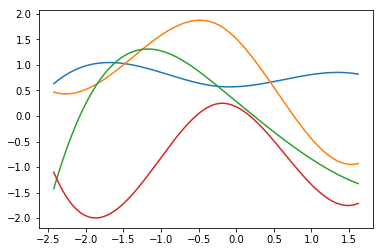

In [734]:
prior_mu, prior_sigma = gp_prior(train_x)

curves_num = 4

ax = plt.subplot(111)

for c in range(curves_num):
    y = np.random.multivariate_normal(prior_mu, prior_sigma)
    
    train_x_smooth, y_smooth = smooth(train_x, y)
    
    ax.plot(train_x_smooth, y_smooth)

/home/mohammedeamer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


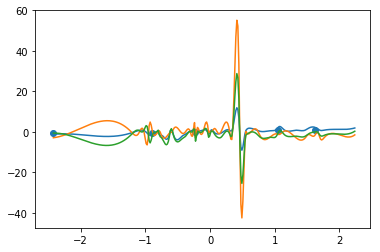

In [735]:
post_mu, post_sigma = gp_posterior(train_x, train_y, test_x)

# post_sigma = np.real(nearPD(post_sigma))

post_curves_num = 3

ax = plt.subplot(111)

for c in range(post_curves_num):
    y_hat = np.random.multivariate_normal(post_mu, post_sigma)
    test_x_smooth, y_hat_smooth = smooth(test_x, y_hat)
    ax.plot(test_x_smooth, y_hat_smooth)

ax.scatter(train_x, train_y)